In [1]:
from NeuralGraph import NeuralGraph
import torch
from torch import nn
import numpy as np
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

C:\Users\Alec\AppData\Local\Temp\ipykernel_27556\770984268.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
device = "cpu"

### New set of equivalent eqns. that are implementable in ANNs

In [3]:
# Now that we have confirmed our functions work perfectly, we will hand implement them in ANNs bc I have no life :)

# To approx. f(x) = 1 if x > 0 else 0 we will use the following:
# ReLU(ax)-ReLU(ax - 1) which for large a is essentially what we want
# To pass a value through a ReLU we will use f(x) = ReLU(x) - ReLU(-x)

# n[0] is activation
# n[1] is bias
# n[2] is dL/dz (pre activation grad)
# n[3] is haslbl
# n[4] is da/dz (ReLU gradient = 1 if a > 0 else 0)
# n[5] is apply_b_grad?

# e[0] is weight
# e[1] is -lr * gradient
# e[2] is apply_w_grad?



# Output: 1 layer MLP
# Easy
# o[0] = n[0]

# Input
# Easy w/ 1 layer MLP
# i[0] = inp[0] - n[0]

# Label: 1 layer MultMLP
# Create another ch_n: n[4] which simply keeps track of (1 if n[0] > 0 else 0), than have this be a multiplication MLP
# l[2] = 2* n[0] * n[4] - 2* lbl[0] * n[4] - n[2] # Have distributed this now so multiplications happen first
# Easy
# l[3] = 1 - n[3]

# Message: 1 layer MultMLP
# Will have to be a mult net
# Easy for a mult net
# m_a[2] = e[0] * n_b[2]
# Easy
# m_a[3] = n_b[3]
# Easy for mult net
# m_b[0] = n_a[0] * e[0]
# Easy for mult net
# m_b[1] = n_b[3] - n_a[3] * n_b[3] # Have distributed again
# This has been broken into two steps: e[1] and e[2] will calculate -lr * n_a[0] * n_b[2] and n_b[3] - n_a[3] * n_b[3] respectively and then next iter they will be combined into e[0]
# m_e[0] = e[1] * e[2]
# m_e[1] = -lr * n_a[0] * n_b[2] - e[1]
# m_e[2] = n_b[3] - n_a[3] * n_b[3] - e[2]

# Update: 2 layer MultMLP
# Has to pass through n[0]
# u[0] = ReLU(agg_m_b[0] + n[1]) - n[0]
# Broke down into intermediate step in n[5], will haev to pass through
# u[1] = -lr * n[2] * n[5]
# Will have to pass through
# u[2] = agg_m_a[2] * n[4] - n[2]
# Use approx. if
# u[3] = (1 if agg_m_a[3] > 0 else 0) - n[3]
# u[4] = (1 if n[0] > 0 else 0) - n[4]
# u[5] = (1 if agg_m_b[1] > 0 else 0) - n[5]

In [4]:
lr=.01
ch_n = 6
ch_e = 3

def ReLU(x):
    return torch.where(x > 0, x, 0)

def desired_inp(x):
    i = torch.zeros(*x.shape[:-1], ch_n).to(device)
    i[..., 0] = x[..., 0] - x[..., 1]
    return i

def desired_out(x):
    return x[..., :1]

def desired_lbl(x):
    lbl, n = torch.tensor_split(x, [1], -1)
    l = torch.zeros(*x.shape[:-1], ch_n).to(device)

    # l[2] = n[0] * n[4] - lbl[0] * n[4] - n[2]
    # l[3] = 1 - n[3]

    l[..., 2] = n[..., 0] * n[..., 4] - lbl[..., 0] * n[..., 4] - n[..., 2]# (n[..., 0] - lbl[..., 0]) * torch.where(n[..., 0] <= 0, 0, 1) - n[..., 2]
    l[..., 3] = 1 - n[..., 3]
    return l

def desired_message(x):
    n_a, n_b, e = torch.tensor_split(x, [ch_n, ch_n*2], -1)
    m_a, m_b, m_e = torch.zeros(*x.shape[:-1], ch_n).to(device), torch.zeros(*x.shape[:-1], ch_n).to(device), torch.zeros(*x.shape[:-1], ch_e).to(device)

    # m_a[2] = e[0] * n_b[2]
    # m_a[3] = n_b[3]
    # m_b[0] = n_a[0] * e[0]
    # m_b[1] = n_b[3] - n_a[3] * n_b[3]
    # m_e[0] = e[1] * e[2]
    # m_e[1] = -lr * n_a[0] * n_b[2] - e[1]
    # m_e[2] = n_b[3] - n_a[3] * n_b[3] - e[2]

    m_a[..., 2] = e[..., 0] * n_b[..., 2]
    m_a[..., 3] = n_b[..., 3]
    m_b[..., 0] = n_a[..., 0] * e[..., 0]
    m_b[..., 1] = n_b[..., 3] - n_a[..., 3] * n_b[..., 3]
    m_e[..., 0] = e[..., 1] * e[..., 2]
    m_e[..., 1] = -lr * n_a[..., 0] * n_b[..., 2] - e[..., 1]
    m_e[..., 2] = n_b[..., 3] - n_a[..., 3] * n_b[..., 3] - e[..., 2]

    return torch.cat([m_a, m_b, m_e], axis=-1)

def desired_update(x):
    agg_m_a, agg_m_b, n = torch.tensor_split(x, [ch_n, ch_n*2], -1)
    u = torch.zeros(*x.shape[:-1], ch_n).to(device)

    # u[0] = ReLU(agg_m_b[0] + n[1]) - n[0]
    # u[1] = -lr * n[2] * n[5]
    # u[2] = agg_m_a[2] * n[4] - n[2]
    # u[3] = (1 if agg_m_a[3] > 0 else 0) - n[3]
    # u[4] = (1 if n[0] > 0 else 0) - n[4]
    # u[5] = (1 if agg_m_b[1] > 0 else 0) - n[5]

    u[..., 0] = ReLU(agg_m_b[..., 0] + n[..., 1]) - n[..., 0]
    u[..., 1] = -lr * n[..., 2] * n[..., 5]
    u[..., 2] = agg_m_a[..., 2] * n[..., 4] - n[..., 2]
    u[..., 3] = torch.where(agg_m_a[..., 3] > 0, 1, 0) - n[..., 3]
    u[..., 4] = torch.where(n[..., 0] > 0, 1, 0) - n[..., 4]
    u[..., 5] = torch.where(agg_m_b[..., 1] > 0, 1, 0) - n[..., 5]

    return u

In [5]:
class Hard_Func(nn.Module): # Wrap them as modules so torch doesn't get angry
    def __init__(self, func):
        super().__init__()
        self.func = func
    def forward(self, x):
        return self.func(x)

In [6]:
size = 7

shape = [size**2, 16, 2]

connections = [(i, j) for k in range(len(shape)-1) for i in range(sum(shape[:k]), sum(shape[:k+1])) for j in range(sum(shape[:k+1]), sum(shape[:k+2]))]
print(len(connections))

graph = NeuralGraph(sum(shape), shape[0], shape[-1], connections, ch_n=ch_n, ch_e=ch_e, clamp_mode="none", value_init="zeros", aggregation="sum", use_label=True, device=device)

graph.inp_int = Hard_Func(desired_inp)# inp_enc.to(device)
graph.out_int = Hard_Func(desired_out)# out_enc.to(device)
graph.label_int = Hard_Func(desired_lbl)# label_enc.to(device)
graph.messages = nn.ModuleList([Hard_Func(desired_message)])# nn.ModuleList([message.to(device)])
graph.updates = nn.ModuleList([Hard_Func(desired_update)])# nn.ModuleList([update.to(device)])

816


In [7]:
class Test_MLP(nn.Module):
    def __init__(self, shape):
        super().__init__()

        modules = []
        for i in range(len(shape)-1):
            modules.append(nn.Linear(shape[i], shape[i+1]))
            modules.append(nn.ReLU())

        self.main = nn.Sequential(*modules)
    
    def forward(self, x):
        return self.main(x)

In [8]:
copycat = Test_MLP(shape).to(device)

In [9]:
# Copy copycat vals to graph
def init_vals(copycat, batch_size=1):
    edge_states = []
    bias_states = []

    for layer in copycat.main[::2]:
        # split_bias = torch.repeat_interleave(layer.bias.clone().unsqueeze(-1), layer.weight.shape[1], axis=-1) / layer.weight.shape[1]
        
        edge_states.append(layer.weight.clone().T.reshape(-1))
        bias_states.append(layer.bias.clone())

    edge_states = torch.cat(edge_states, axis=0)
    bias_states = torch.cat([torch.zeros(shape[0]).to(device), *bias_states], axis=0)

    graph.init_vals(batch_size=batch_size)
    graph.edges[:, :, 0] = edge_states.clone().unsqueeze(0)
    graph.nodes[:, :, 1] = bias_states

def get_grads(copycat):
    edge_grads = []
    bias_grads = []

    for layer in copycat.main[::2]:
        # split_bias = torch.repeat_interleave(layer.bias.clone().unsqueeze(-1), layer.weight.shape[1], axis=-1) / layer.weight.shape[1]
        
        edge_grads.append(layer.weight.grad.clone().T.reshape(-1))
        bias_grads.append(layer.bias.grad.clone())

    edge_grads = torch.cat(edge_grads, axis=0)
    bias_grads = torch.cat([torch.zeros(shape[0]).to(device), *bias_grads], axis=0)
    return edge_grads, bias_grads

In [10]:
init_vals(copycat)

dummy_inp = torch.randn(1, 49).to(device)
dummy_label = torch.randn(1, 2).to(device)

print(copycat(dummy_inp))
print(graph.forward(dummy_inp))

tensor([[0.0254, 0.0182]], grad_fn=<ReluBackward0>)
tensor([[0.0254, 0.0182]], grad_fn=<SqueezeBackward1>)


In [11]:
copycat.zero_grad()

out = copycat(dummy_inp)
loss = torch.square(dummy_label - out).mean()

loss.backward()

w_grad, b_grad = get_grads(copycat)

print(w_grad.shape, b_grad.shape)

torch.Size([816]) torch.Size([67])


In [12]:
init_vals(copycat)

old_w = graph.edges[..., 0].clone().flatten()
old_b = graph.nodes[..., 1].clone().flatten()
graph.forward(dummy_inp, edges=True)
graph.backward(dummy_inp, dummy_label, edges=True)

# The negative lr has already been mult. so divide out
delta_w = (graph.edges[..., 0].flatten() - old_w.flatten()) / -lr

delta_b = (graph.nodes[..., 1].flatten() - old_b.flatten()) / -lr

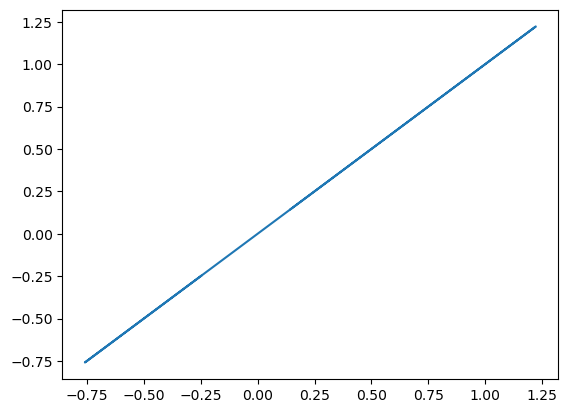

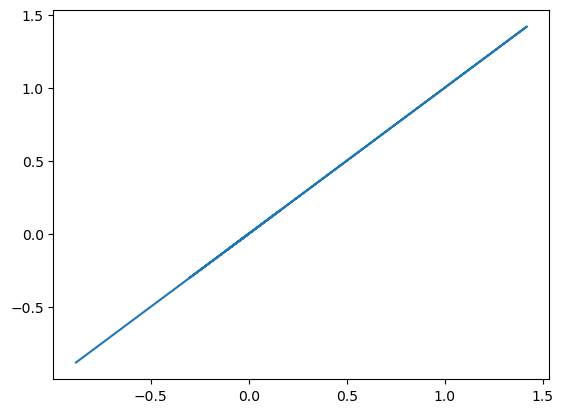

In [13]:
plt.plot(delta_w.detach().cpu(), w_grad.detach().cpu())
plt.show()

plt.plot(delta_b.detach().cpu(), b_grad.detach().cpu())
plt.show()

In [60]:
# Increasing a from 100_000 to 1_000_000 makes everything break for some reason
# a = 10_000 causes significant differences after a long period of time
a = 100_000

# Now that we have confirmed our functions work perfectly, we will hand implement them in ANNs bc I have no life :)

# To approx. f(x) = 1 if x > 0 else 0 we will use the following:
# ReLU(ax)-ReLU(ax - 1) which for large a is essentially what we want
# To pass a value through a ReLU we will use f(x) = ReLU(x) - ReLU(-x)

# ch_n = 6
# ch_e = 3

# n[0] is activation
# n[1] is bias
# n[2] is dL/dz (pre activation grad)
# n[3] is haslbl
# n[4] is da/dz (ReLU gradient = 1 if a > 0 else 0)
# n[5] is apply_b_grad?

# e[0] is weight
# e[1] is -lr * gradient
# e[2] is apply_w_grad?



# Output: 1 layer MLP
# Easy
# o[0] = n[0]

# Input
# Easy w/ 1 layer MLP
# i[0] = inp[0] - n[0]

# Label: 1 layer MultMLP
# Create another ch_n: n[4] which simply keeps track of (1 if n[0] > 0 else 0), than have this be a multiplication MLP
# l[2] = 2 * n[0] * n[4] - 2 * lbl[0] * n[4] - n[2] # Have distributed this now so multiplications happen first
# Easy
# l[3] = 1 - n[3]

# Message: 1 layer MultMLP
# Will have to be a mult net
# Easy for a mult net
# m_a[2] = e[0] * n_b[2]
# Easy
# m_a[3] = n_b[3]
# Easy for mult net
# m_b[0] = n_a[0] * e[0]
# Easy for mult net
# m_b[1] = n_b[3] - n_a[3] * n_b[3] # Have distributed again
# This has been broken into two steps: e[1] and e[2] will calculate -lr * n_a[0] * n_b[2] and n_b[3] - n_a[3] * n_b[3] respectively and then next iter they will be combined into e[0]
# m_e[0] = e[1] * e[2]
# m_e[1] = -lr * n_a[0] * n_b[2] - e[1]
# m_e[2] = n_b[3] - n_a[3] * n_b[3] - e[2]

# Update: 2 layer MultMLP
# Has to pass through n[0]
# u[0] = ReLU(agg_m_b[0] + n[1]) - n[0]
# Broke down into intermediate step in n[5], will haev to pass through
# u[1] = -lr * n[2] * n[5]
# Will have to pass through
# u[2] = agg_m_a[2] * n[4] - n[2]
# Use approx. if
# u[3] = (1 if agg_m_a[3] > 0 else 0) - n[3]
# u[4] = (1 if n[0] > 0 else 0) - n[4]
# u[5] = (1 if agg_m_b[1] > 0 else 0) - n[5]

In [61]:
# Scratch work for figuring out indices
print({i+18:conn for i, conn in enumerate([(i, j) for i in range(18) for j in range(i+1, 18)])})

{18: (0, 1), 19: (0, 2), 20: (0, 3), 21: (0, 4), 22: (0, 5), 23: (0, 6), 24: (0, 7), 25: (0, 8), 26: (0, 9), 27: (0, 10), 28: (0, 11), 29: (0, 12), 30: (0, 13), 31: (0, 14), 32: (0, 15), 33: (0, 16), 34: (0, 17), 35: (1, 2), 36: (1, 3), 37: (1, 4), 38: (1, 5), 39: (1, 6), 40: (1, 7), 41: (1, 8), 42: (1, 9), 43: (1, 10), 44: (1, 11), 45: (1, 12), 46: (1, 13), 47: (1, 14), 48: (1, 15), 49: (1, 16), 50: (1, 17), 51: (2, 3), 52: (2, 4), 53: (2, 5), 54: (2, 6), 55: (2, 7), 56: (2, 8), 57: (2, 9), 58: (2, 10), 59: (2, 11), 60: (2, 12), 61: (2, 13), 62: (2, 14), 63: (2, 15), 64: (2, 16), 65: (2, 17), 66: (3, 4), 67: (3, 5), 68: (3, 6), 69: (3, 7), 70: (3, 8), 71: (3, 9), 72: (3, 10), 73: (3, 11), 74: (3, 12), 75: (3, 13), 76: (3, 14), 77: (3, 15), 78: (3, 16), 79: (3, 17), 80: (4, 5), 81: (4, 6), 82: (4, 7), 83: (4, 8), 84: (4, 9), 85: (4, 10), 86: (4, 11), 87: (4, 12), 88: (4, 13), 89: (4, 14), 90: (4, 15), 91: (4, 16), 92: (4, 17), 93: (5, 6), 94: (5, 7), 95: (5, 8), 96: (5, 9), 97: (5, 10)

In [62]:
class Inp_Enc(nn.Module):
    def __init__(self, ch_inp, ch_n, *args, **kwargs):
        super().__init__()

        # 1 layer MLP
        self.main = nn.Linear(ch_inp+ch_n, ch_n)

        with torch.no_grad():
            self.main.weight.fill_(0)
            self.main.bias.fill_(0)
            
            # i[0] = inp[0] - n[0]
            self.main.weight[0, 0] = 1
            self.main.weight[0, 1] = 1

    def forward(self, x):
        return self.main(x)

class Label_Enc(nn.Module):
    def __init__(self, ch_out, ch_n, *args, **kwargs):
        super().__init__()

        # 1 layer MultMLP
        inps = ch_out+ch_n
        self.main = nn.Linear(inps + int((inps-1)*inps/2), 6)

        with torch.no_grad():
            self.main.weight.fill_(0)
            self.main.bias.fill_(0)

            # l[2] = 2 * n[0] * n[4] - 2 * lbl[0] * n[4] - n[2]
            self.main.weight[2, 16] = 2
            self.main.weight[2, 11] = -2
            self.main.weight[2, 3] = -1
            # l[3] = 1 - n[3]
            self.main.bias[3] = 1
            self.main.weight[3, 4] = -1
            pass

    def forward(self, x):
        mult_x = torch.cat([x, *[x[..., i:i+1] * x[..., j:j+1] for i in range(x.shape[-1]) for j in range(i+1, x.shape[-1])]], axis=-1)
        return self.main(mult_x)

class Out_Dec(nn.Module):
    def __init__(self, ch_out, ch_n, *args, **kwargs):
        super().__init__()

        self.main = nn.Linear(ch_n, ch_out)

        with torch.no_grad():
            self.main.weight.fill_(0)
            self.main.bias.fill_(0)

            # o[0] = n[0]
            self.main.weight[0, 0] = 1

    def forward(self, x):
        return self.main(x)


class Message(nn.Module):
    def __init__(self, ch_n, ch_e, *args, **kwargs):
        super().__init__()

        self.ch_n = ch_n
        self.ch_e = ch_e

        inp = 2*ch_n + ch_e

        self.main = nn.Linear(inp + int((inp-1)*inp/2), 2*ch_n + ch_e)

        with torch.no_grad():
            self.main.weight.fill_(0)
            self.main.bias.fill_(0)

            # m_a[2] = e[0] * n_b[2] # (8, 12)
            self.main.weight[2, 102] = 1
            # m_a[3] = n_b[3]
            self.main.weight[3, 9] = 1
            # m_b[0] = n_a[0] * e[0] # (0, 12)
            self.main.weight[6, 26] = 1
            # m_b[1] = n_b[3] - n_a[3] * n_b[3] # (3, 9)
            self.main.weight[7, 9] = 1
            self.main.weight[7, 59] = -1
            # m_e[0] = e[1] * e[2] # (13, 14)
            self.main.weight[12, 119] = 1
            # m_e[1] = -lr * n_a[0] * n_b[2] - e[1] # (0, 8)
            self.main.weight[13, 22] = -lr
            self.main.weight[13, 13] = -1
            # m_e[2] = n_b[3] - n_a[3] * n_b[3] - e[2] # (3, 9)
            self.main.weight[14, 9] = 1
            self.main.weight[14, 59] = -1
            self.main.weight[14, 14] = -1
            
    def forward(self, x):
        mult_x = torch.cat([x, *[x[..., i:i+1] * x[..., j:j+1] for i in range(x.shape[-1]) for j in range(i+1, x.shape[-1])]], axis=-1)
        return self.main(mult_x)
    
class Update(nn.Module):
    def __init__(self, ch_n, *args, **kwargs):
        super().__init__()

        inp = 3*ch_n

        self.main = nn.Sequential(
            nn.Linear(inp + int((inp-1)*inp/2), 20),
            nn.ReLU(),
            nn.Linear(20, ch_n),
        )

        with torch.no_grad():
            self.main[0].weight.fill_(0)
            self.main[0].bias.fill_(0)
            self.main[2].weight.fill_(0)
            self.main[2].bias.fill_(0)

            # u[0] = ReLU(agg_m_b[0] + n[1]) - n[0] # first part in h[0] and pass -n[0] through in h[1] and h[2] and reconstructed
            self.main[0].weight[0, 6] = 1
            self.main[0].weight[0, 13] = 1
            self.main[0].weight[1, 12] = -1
            self.main[0].weight[2, 12] = 1
            self.main[2].weight[0, 0] = 1
            self.main[2].weight[0, 1] = 1
            self.main[2].weight[0, 2] = -1
            # u[1] = -lr * n[2] * n[5] # (14, 17) pass through h[3] and h[4]
            self.main[0].weight[3, 167] = -lr
            self.main[0].weight[4, 167] = lr
            self.main[2].weight[1, 3] = 1
            self.main[2].weight[1, 4] = -1
            # u[2] = agg_m_a[2] * n[4] - n[2] # (2, 16) pass through h[5] and h[6]
            self.main[0].weight[5, 64] = 1
            self.main[0].weight[5, 14] = -1
            self.main[0].weight[6, 64] = -1
            self.main[0].weight[6, 14] = 1
            self.main[2].weight[2, 5] = 1
            self.main[2].weight[2, 6] = -1
            # u[3] = (1 if agg_m_a[3] > 0 else 0) - n[3] # Do the iffy thing in h[7] and h[8] and pass through -n[3] in h[9] and h[10]
            # ReLU(ax)-ReLU(ax - 1)
            self.main[0].weight[7, 3] = a
            self.main[0].weight[8, 3] = a
            self.main[0].bias[8] = -1
            self.main[2].weight[3, 7] = 1
            self.main[2].weight[3, 8] = -1
            # Pass through -n[3]
            self.main[0].weight[9, 15] = -1
            self.main[0].weight[10, 15] = 1
            self.main[2].weight[3, 9] = 1
            self.main[2].weight[3, 10] = -1
            # u[4] = (1 if n[0] > 0 else 0) - n[4] # Same as last with minor tweaks (using h[11], h[12], h[13], h[14])
            # ReLU(ax)-ReLU(ax - 1)
            self.main[0].weight[11, 12] = a
            self.main[0].weight[12, 12] = a
            self.main[0].bias[12] = -1
            self.main[2].weight[4, 11] = 1
            self.main[2].weight[4, 12] = -1
            # Pass through -n[4]
            self.main[0].weight[13, 16] = -1
            self.main[0].weight[14, 16] = 1
            self.main[2].weight[4, 13] = 1
            self.main[2].weight[4, 14] = -1
            # u[5] = (1 if agg_m_b[1] > 0 else 0) - n[5] # Same as last with minor tweaks (using h[15], h[16], h[17], h[18])
            # ReLU(ax)-ReLU(ax - 1)
            self.main[0].weight[15, 7] = a
            self.main[0].weight[16, 7] = a
            self.main[0].bias[16] = -1
            self.main[2].weight[5, 15] = 1
            self.main[2].weight[5, 16] = -1
            # Pass through -n[5]
            self.main[0].weight[17, 17] = -1
            self.main[0].weight[18, 17] = 1
            self.main[2].weight[5, 17] = 1
            self.main[2].weight[5, 18] = -1
    
    def forward(self, x):
        mult_x = torch.cat([x, *[x[..., i:i+1] * x[..., j:j+1] for i in range(x.shape[-1]) for j in range(i+1, x.shape[-1])]], axis=-1)
        return self.main(mult_x)

In [63]:
size = 7

shape = [size**2, 16, 10]

connections = [(i, j) for k in range(len(shape)-1) for i in range(sum(shape[:k]), sum(shape[:k+1])) for j in range(sum(shape[:k+1]), sum(shape[:k+2]))]
print(len(connections))

graph = NeuralGraph(sum(shape), shape[0], shape[-1], connections, ch_n=ch_n, ch_e=ch_e, clamp_mode="none", value_init="zeros", aggregation="sum", use_label=True, device=device,
                     message_generator=Message, update_generator=Update, inp_int_generator=Inp_Enc, label_int_generator=Label_Enc, out_int_generator=Out_Dec)

944


In [64]:
class Test_MLP(nn.Module):
    def __init__(self, shape):
        super().__init__()

        modules = []
        for i in range(len(shape)-1):
            modules.append(nn.Linear(shape[i], shape[i+1]))
            modules.append(nn.ReLU())

        self.main = nn.Sequential(*modules)
    
    def forward(self, x):
        return self.main(x)

In [65]:
copycat = Test_MLP(shape).to(device)

In [66]:
def get_states(copycat):
    edge_states = []
    bias_states = []

    for layer in copycat.main[::2]:
        # split_bias = torch.repeat_interleave(layer.bias.clone().unsqueeze(-1), layer.weight.shape[1], axis=-1) / layer.weight.shape[1]
        
        edge_states.append(layer.weight.clone().T.reshape(-1))
        bias_states.append(layer.bias.clone())

    edge_states = torch.cat(edge_states, axis=0)
    bias_states = torch.cat([torch.zeros(shape[0]).to(device), *bias_states], axis=0)
    return edge_states.clone().detach(), bias_states.clone().detach()

# Copy copycat vals to graph
def init_vals(copycat, batch_size=1):
    edge_states, bias_states = get_states(copycat)

    graph.init_vals(batch_size=batch_size)
    graph.edges[:, :, 0] = edge_states.detach().clone()
    graph.nodes[:, :, 1] = bias_states.detach().clone()

def get_grads(copycat):
    edge_grads = []
    bias_grads = []

    for layer in copycat.main[::2]:
        # split_bias = torch.repeat_interleave(layer.bias.clone().unsqueeze(-1), layer.weight.shape[1], axis=-1) / layer.weight.shape[1]
        
        edge_grads.append(layer.weight.grad.clone().T.reshape(-1))
        bias_grads.append(layer.bias.grad.clone())

    edge_grads = torch.cat(edge_grads, axis=0)
    bias_grads = torch.cat([torch.zeros(shape[0]).to(device), *bias_grads], axis=0)
    return edge_grads, bias_grads

In [67]:
dummy_inp = torch.randn(1, 49).to(device)
dummy_label = torch.randn(1, 10).to(device)

In [68]:
copycat = Test_MLP(shape).to(device)
optimizer = torch.optim.SGD(copycat.parameters(), lr=.01)

init_vals(copycat)


old_w, old_b = get_states(copycat)

graph_old_w = graph.edges[..., 0].clone().flatten()
graph_old_b = graph.nodes[..., 1].clone().flatten()

diffs = []

for _ in range(10):

    optimizer.zero_grad()

    FFN_out = copycat(dummy_inp)
    loss = torch.square(dummy_label - FFN_out).sum(-1).mean()
    loss.backward()

    # print(copycat.main[2].weight.grad)
    
    optimizer.step()

    with torch.no_grad():

        graph_out = graph.forward(dummy_inp, edges=True)
        graph.backward(dummy_inp, dummy_label, edges=True)



    w, b = get_states(copycat)
    FFN_delta_w, FFN_delta_b = w - old_w, b - old_b
    # The negative lr has already been mult. so divide out
    delta_w = (graph.edges[..., 0].flatten() - graph_old_w.flatten())
    delta_b = (graph.nodes[..., 1].flatten() - graph_old_b.flatten())

    diffs.append(torch.abs(FFN_delta_w - delta_w).mean())

    # nonzero = torch.argwhere(FFN_delta_w != 0).flatten()
    # print(FFN_delta_w[nonzero], delta_w[nonzero])
    # print(torch.abs(FFN_delta_w[nonzero] - delta_w[nonzero]).mean())
# print(FFN_out, graph_out)

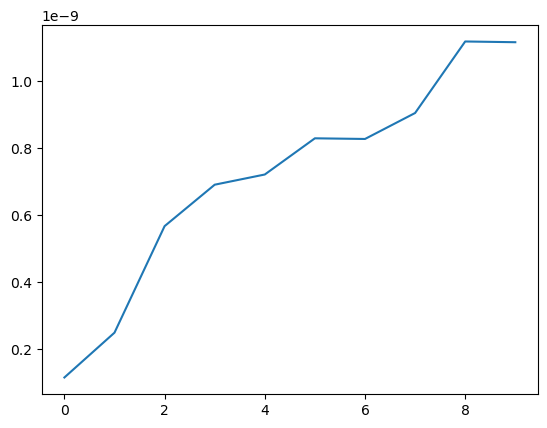

In [69]:
plt.plot(diffs)

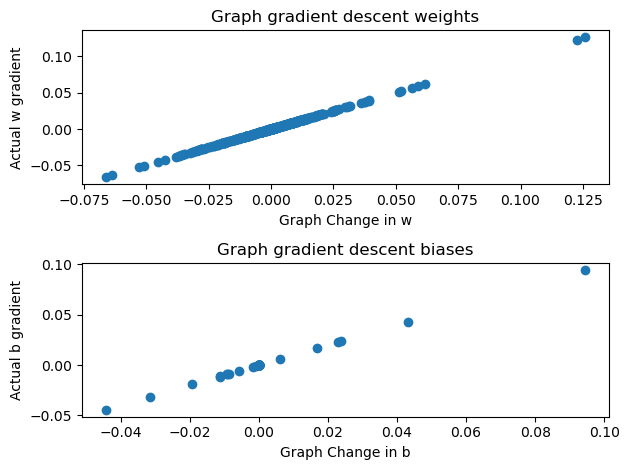

In [70]:
plt.subplot(2, 1, 1)

plt.title("Graph gradient descent weights")
plt.ylabel("Actual w gradient")
plt.xlabel("Graph Change in w")
plt.scatter(FFN_delta_w.detach().cpu(), delta_w.detach().cpu())

plt.subplot(2, 1, 2)

plt.title("Graph gradient descent biases")
plt.ylabel("Actual b gradient")
plt.xlabel("Graph Change in b")
plt.scatter(FFN_delta_b.detach().cpu(), delta_b.detach().cpu())

plt.tight_layout()

plt.show()

In [71]:
import tensorflow as tf
import cv2

In [72]:
SIZE = 7

(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = np.stack([cv2.resize(img/255.0, dsize=[SIZE, SIZE]) for img in x_train]).reshape(-1, SIZE**2)

x_train = torch.Tensor(x_train).to(device)
y_train = nn.functional.one_hot(torch.Tensor(y_train).to(device).long(), 10)

In [73]:
shape = [SIZE**2, 16, 16, 10]

connections = [(i, j) for k in range(len(shape)-1) for i in range(sum(shape[:k]), sum(shape[:k+1])) for j in range(sum(shape[:k+1]), sum(shape[:k+2]))]
print(len(connections))

graph = NeuralGraph(sum(shape), shape[0], shape[-1], connections, ch_n=ch_n, ch_e=ch_e, clamp_mode="none", value_init="zeros", aggregation="sum", use_label=True, device=device,
                     message_generator=Message, update_generator=Update, inp_int_generator=Inp_Enc, label_int_generator=Label_Enc, out_int_generator=Out_Dec)

1200


In [74]:
# graph.edges[..., 0] = torch.randn_like(graph.edges[..., 0])

In [75]:
print(x_train.shape, y_train.shape)

torch.Size([60000, 49]) torch.Size([60000, 10])


In [76]:
criterion = nn.MSELoss()

In [77]:
# Copy copycat vals to graph
def init_vals(copycat, batch_size=1):
    edge_states = []
    bias_states = []

    for layer in copycat.main[::2]:
        # split_bias = torch.repeat_interleave(layer.bias.clone().unsqueeze(-1), layer.weight.shape[1], axis=-1) / layer.weight.shape[1]
        
        edge_states.append(layer.weight.clone().T.reshape(-1))
        bias_states.append(layer.bias.clone())

    edge_states = torch.cat(edge_states, axis=0)
    bias_states = torch.cat([torch.zeros(shape[0]).to(device), *bias_states], axis=0)

    graph.init_vals(batch_size=batch_size)
    graph.edges[:, :, 0] = edge_states.clone().unsqueeze(0)
    graph.nodes[:, :, 1] = bias_states

def get_grads(copycat):
    edge_grads = []
    bias_grads = []

    for layer in copycat.main[::2]:
        # split_bias = torch.repeat_interleave(layer.bias.clone().unsqueeze(-1), layer.weight.shape[1], axis=-1) / layer.weight.shape[1]
        
        edge_grads.append(layer.weight.grad.clone().T.reshape(-1))
        bias_grads.append(layer.bias.grad.clone())

    edge_grads = torch.cat(edge_grads, axis=0)
    bias_grads = torch.cat([torch.zeros(shape[0]).to(device), *bias_grads], axis=0)
    return edge_grads, bias_grads

In [78]:
copycat = Test_MLP(shape).to(device)
optimizer = torch.optim.SGD(copycat.parameters(), lr=.01)

init_vals(copycat)

old_w, old_b = get_states(copycat)

graph_old_w = graph.edges[..., 0].clone().flatten()
graph_old_b = graph.nodes[..., 1].clone().flatten()

graph_losses = []
ANN_losses = []
diffs = []

bar = tqdm(zip(x_train, y_train), total=len(x_train))
for x, y in bar:
    x = x.reshape(1, -1)
    y = y.reshape(1, -1)

    optimizer.zero_grad()
    out = copycat(x)
    ANN_loss = torch.square(y - out).sum(-1).mean()
    ANN_loss.backward()
    optimizer.step()

    with torch.no_grad():
        y_pred = graph.forward(x, edges=True)
        graph.backward(x, y, edges=True)    

        loss = torch.square(y - y_pred).sum(-1).mean()# criterion(y.flatten(), y_pred.flatten()) * 10
    
    graph_losses.append(loss.item())
    ANN_losses.append(ANN_loss.item())
    
    w, b = get_states(copycat)
    FFN_delta_w, FFN_delta_b = w - old_w, b - old_b
    # The negative lr has already been mult. so divide out
    delta_w = (graph.edges[..., 0].flatten() - graph_old_w.flatten())
    delta_b = (graph.nodes[..., 1].flatten() - graph_old_b.flatten())

    # Percent diff
    # print(torch.abs(delta_w).mean().item())
    diff = (torch.abs(FFN_delta_w - delta_w).mean() / torch.abs(FFN_delta_w).mean()).item()

    diffs.append(diff)

    bar.set_postfix({"graph_loss":loss.item(), "ANN_loss":ANN_loss.item(), "diff":diff})

  0%|          | 0/60000 [00:00<?, ?it/s]

KeyboardInterrupt: 

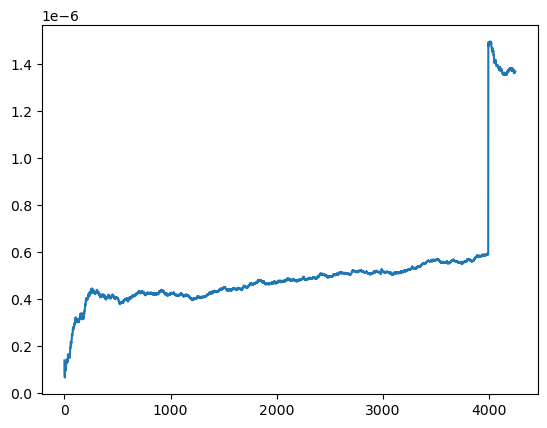

In [79]:
plt.plot(diffs)

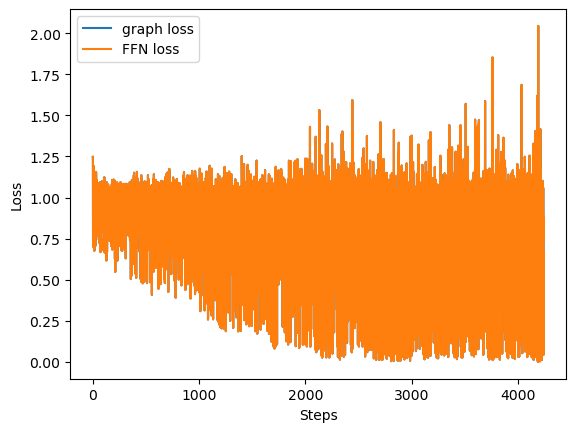

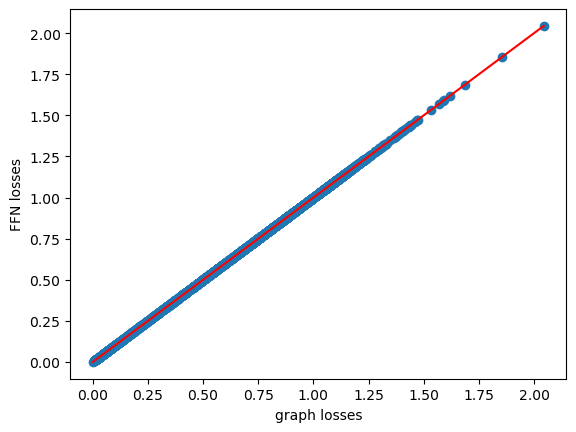

In [80]:
plt.plot(graph_losses, label="graph loss")
plt.plot(ANN_losses, label="FFN loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.scatter(graph_losses, ANN_losses)
plt.plot([np.min(graph_losses), np.max(graph_losses)], [np.min(graph_losses), np.max(graph_losses)], c="red")
plt.xlabel("graph losses")
plt.ylabel("FFN losses")
plt.show()
# plt.ylim(0, 1)
# plt.show()

In [ ]:
# Ordered shit

# o[0] = n[0]

# i[0] = inp[0] - n[0]

# l[2] = 2 * (n[0] - lbl) * (0 if n[0] <= 0 else 1) - n[2]
# l[3] = 1 - n[3]

# m_a[2] = e[0] * n_b[2]
# m_a[3] = n_b[3]
# m_b[0] = n_a[0] * e[0]
# m_b[1] = (1-n_a[3]) * n_b[3]
# m_e[0] = -lr * n_a[0] * n_b[2] * (1-n_a[3]) * n_b[3]

# u[0] = ReLU(agg_m_b[0] + n[1]) - n[0]
# u[1] = (-lr*n[2] if agg_m_b[1] > 0 else 0)
# u[2] = agg_m_a[2] * (0 if n[0] <= 0 else 1) - n[2]
# u[3] = (1 if agg_m_a[3] > 0 else 0) - n[3]

lr=.01
ch_n = 4
ch_e = 1

def desired_inp(x):
    i = torch.zeros(*x.shape[:-1], ch_n).to(device)
    i[..., 0] = x[..., 0] - x[..., 1]
    return i

def desired_out(x):
    return x[..., :1]

def desired_lbl(x):
    lbl, n = torch.tensor_split(x, [1], -1)
    l = torch.zeros(*x.shape[:-1], ch_n).to(device)
    l[..., 2] = (n[..., 0] - lbl[..., 0]) * torch.where(n[..., 0] <= 0, 0, 1) - n[..., 2]
    l[..., 3] = 1 - n[..., 3]
    return l

def desired_message(x):
    n_a, n_b, e = torch.tensor_split(x, [ch_n, ch_n*2], -1)
    m_a, m_b, m_e = torch.zeros(*x.shape[:-1], ch_n).to(device), torch.zeros(*x.shape[:-1], ch_n).to(device), torch.zeros(*x.shape[:-1], ch_e).to(device)

    m_a[..., 2] = e[..., 0] * n_b[..., 2]
    m_a[..., 3] = n_b[..., 3]
    m_b[..., 0] = n_a[..., 0] * e[..., 0]
    m_b[..., 1] = (1-n_a[..., 3]) * n_b[..., 3]
    m_e[..., 0] = -lr * n_a[..., 0] * n_b[..., 2] * (1-n_a[..., 3]) * n_b[..., 3] # Could I do this in 2 timesteps w/ two additional channels????

    # print(m_a.shape, m_b.shape, m_e.shape)

    return torch.cat([m_a, m_b, m_e], axis=-1)

def ReLU(x):
    return torch.where(x > 0, x, 0)

def desired_update(x):
    agg_m_a, agg_m_b, n = torch.tensor_split(x, [ch_n, ch_n*2], -1)
    u = torch.zeros(*x.shape[:-1], ch_n).to(device)

    u[..., 0] = ReLU(agg_m_b[..., 0] + n[..., 1]) - n[..., 0]
    u[..., 1] = torch.where(agg_m_b[..., 1] > 0, -lr*n[..., 2], 0)
    u[..., 2] = agg_m_a[..., 2] * torch.where(n[..., 0] <= 0, 0, 1) - n[..., 2]
    u[..., 3] = torch.where(agg_m_a[..., 3] > 0, 1, 0) - n[..., 3]

    return u

In [ ]:
class Hard_Func(nn.Module): # Wrap them as modules so torch doesn't get angry
    def __init__(self, func):
        super().__init__()
        self.func = func
    def forward(self, x):
        return self.func(x)

In [ ]:
size = 7

shape = [size**2, 16, 2]

connections = [(i, j) for k in range(len(shape)-1) for i in range(sum(shape[:k]), sum(shape[:k+1])) for j in range(sum(shape[:k+1]), sum(shape[:k+2]))]
print(len(connections))

graph = NeuralGraph(sum(shape), shape[0], shape[-1], connections, ch_n=4, ch_e=1, clamp_mode="none", value_init="zeros", aggregation="sum", use_label=True, device=device)

graph.inp_int = Hard_Func(desired_inp)# inp_enc.to(device)
graph.out_int = Hard_Func(desired_out)# out_enc.to(device)
graph.label_int = Hard_Func(desired_lbl)# label_enc.to(device)
graph.messages = nn.ModuleList([Hard_Func(desired_message)])# nn.ModuleList([message.to(device)])
graph.updates = nn.ModuleList([Hard_Func(desired_update)])# nn.ModuleList([update.to(device)])

816


In [ ]:
class Test_MLP(nn.Module):
    def __init__(self, shape):
        super().__init__()

        modules = []
        for i in range(len(shape)-1):
            modules.append(nn.Linear(shape[i], shape[i+1]))
            modules.append(nn.ReLU())

        self.main = nn.Sequential(*modules)
    
    def forward(self, x):
        return self.main(x)

In [ ]:
copycat = Test_MLP(shape).to(device)

In [ ]:
# Copy copycat vals to graph
def init_vals(copycat, batch_size=1):
    edge_states = []
    bias_states = []

    for layer in copycat.main[::2]:
        # split_bias = torch.repeat_interleave(layer.bias.clone().unsqueeze(-1), layer.weight.shape[1], axis=-1) / layer.weight.shape[1]
        
        edge_states.append(layer.weight.clone().T.reshape(-1, 1))
        bias_states.append(layer.bias.clone())

    edge_states = torch.cat(edge_states, axis=0)
    bias_states = torch.cat([torch.zeros(shape[0]).to(device), *bias_states], axis=0)

    graph.init_vals(batch_size=batch_size)
    graph.edges = edge_states.clone().unsqueeze(0)
    graph.nodes[:, :, 1] = bias_states

def get_grads(copycat):
    edge_grads = []
    bias_grads = []

    for layer in copycat.main[::2]:
        # split_bias = torch.repeat_interleave(layer.bias.clone().unsqueeze(-1), layer.weight.shape[1], axis=-1) / layer.weight.shape[1]
        
        edge_grads.append(layer.weight.grad.clone().T.reshape(-1))
        bias_grads.append(layer.bias.grad.clone())

    edge_grads = torch.cat(edge_grads, axis=0)
    bias_grads = torch.cat([torch.zeros(shape[0]).to(device), *bias_grads], axis=0)
    return edge_grads, bias_grads

In [ ]:
init_vals(copycat)

dummy_inp = torch.randn(1, 49).to(device)
dummy_label = torch.randn(1, 2).to(device)

print(copycat(dummy_inp))
print(graph.forward(dummy_inp))

tensor([[0.1079, 0.7500]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[0.1079, 0.7500]], device='cuda:0', grad_fn=<SqueezeBackward1>)


In [ ]:
copycat.zero_grad()

out = copycat(dummy_inp)
loss = torch.square(dummy_label - out).mean()

loss.backward()

w_grad, b_grad = get_grads(copycat)

print(w_grad.shape, b_grad.shape)

torch.Size([816]) torch.Size([67])


In [ ]:
init_vals(copycat)

old_w = graph.edges.clone().flatten()
old_b = graph.nodes[..., 1].clone().flatten()
graph.forward(dummy_inp, edges=True)
graph.backward(dummy_inp, dummy_label, edges=True)

# The negative lr has already been mult. so divide out
delta_w = (graph.edges.flatten() - old_w.flatten()) / -lr

delta_b = (graph.nodes[..., 1].flatten() - old_b.flatten()) / -lr

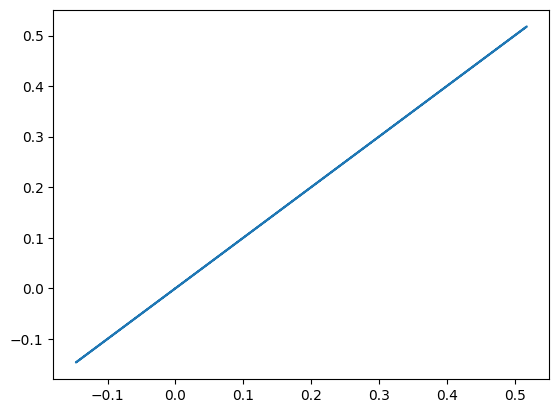

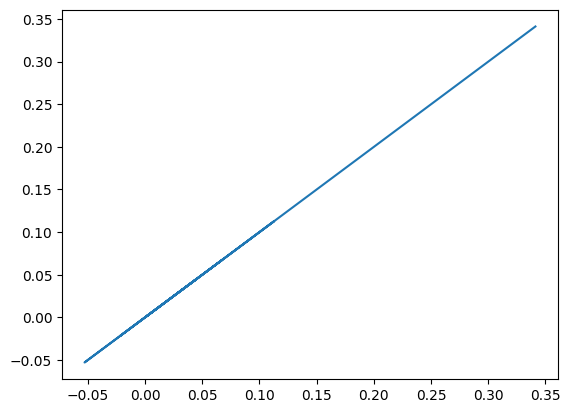

In [ ]:
plt.plot(delta_w.detach().cpu(), w_grad.detach().cpu())
plt.show()

plt.plot(delta_b.detach().cpu(), b_grad.detach().cpu())
plt.show()

In [285]:
# Value for approx. funcs.
a = .01

lr = .01

In [287]:
# out1 = np.arange(4)
# print([out1, *[(i, j) for i in range(out1.shape[-1]) for j in range(i+1, out1.shape[-1])]])

[array([0, 1, 2, 3]), (0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


In [288]:
class Inp_Enc(nn.Module):
    def __init__(self, ch_inp, ch_n, *args, **kwargs):
        super().__init__()

        self.main = nn.Linear(ch_inp+ch_n, ch_n)

        with torch.no_grad():
            self.main.weight.fill_(0)
            self.main.bias.fill_(0)

            # Channel n[0] should be inp - prev n[0]
            self.main.weight[0, 0] = 1
            self.main.weight[0, 1] = 1

    def forward(self, x):
        return self.main(x)
    
class Label_Enc(nn.Module):
    def __init__(self, ch_out, ch_n, *args, **kwargs):
        super().__init__()

        self.l1 = nn.Sequential(
            nn.Linear(ch_out+ch_n, 6),
            nn.ReLU(),
            nn.Linear(6, 4), # Ends up with [n[3] update, dL/dn[0], dn[0]/dz, prev. n[2]]
        )
        # Have to do a multiplication between these two layers
        # Takes as inp: [0, 1, 2, 3, 0*1, 0*2, 0*3, 1*2, 1*3, 2*3]
        self.l2 = nn.Linear(4+int(4*(4-1)/2), ch_n)

        with torch.no_grad():
            self.l1[0].weight.fill_(0)
            self.l1[0].bias.fill_(0)
            self.l1[2].weight.fill_(0)
            self.l1[2].bias.fill_(0)
            self.l2.weight.fill_(0)
            self.l2.bias.fill_(0)

            # Set n[3] = 1 (and subtract out last val)
            self.l1[0].weight[0, ch_out+ch_n-1] = -1
            self.l1[0].bias[0] = 1

            self.l1[2].weight[0, 0] = 1
            self.l2.weight[ch_n-1, 0] = 1



            # Get dL/dn[0] = 2*(n[0] - lbl) (keep neg val for ReLU trick)
            self.l1[0].weight[1, ch_out] = 2
            self.l1[0].weight[1, 0] = -2
            # neg version
            self.l1[0].weight[2, ch_out] = -2
            self.l1[0].weight[2, 0] = 2
            # Combine the two
            self.l1[2].weight[1, 1] = 1
            self.l1[2].weight[1, 2] = -1

            # Now calc. approx. of dReLU(z)/dz using 1-(1/a) * ReLU(-n[0]+a) (since n[0] is already ReLU(z) this will approx dReLU(z)/dz when a is small)
            self.l1[0].weight[3, ch_out] = -1
            self.l1[0].bias[3] = a
            self.l1[2].weight[2, 3] = -1/a
            self.l1[2].bias[2] = 1

            # Also keep prev value around to subtract at the end
            self.l1[0].weight[4, ch_out+2] = 1
            self.l1[0].weight[5, ch_out+2] = -1
            self.l1[2].weight[3, 4] = 1
            self.l1[2].weight[3, 5] = -1

            # Now get mult. of dReLU(z)/dz and dL/dn[0] which should be dL/dz and subtract prev. value
            self.l2.weight[2, 7] = 1 # 7 is where dReLU(z)/dz * dL/dn[0] is located
            self.l2.weight[2, 3] = -1

        
            


    def forward(self, x):
        out1 = self.l1(x)
        # Gets multiplications of layers
        x2 = torch.cat([out1, *[out1[..., i:i+1] * out1[..., j:j+1] for i in range(out1.shape[-1]) for j in range(i+1, out1.shape[-1])]], axis=-1)
        print(x2)
        return self.l2(x2)

class Out_Dec(nn.Module):
    def __init__(self, ch_out, ch_n, *args, **kwargs):
        super().__init__()

        self.main = nn.Linear(ch_n, ch_out)

        with torch.no_grad():
            self.main.weight.fill_(0)
            self.main.bias.fill_(0)

            # Output is just n[0]
            self.main.weight[0, 0] = 1

    def forward(self, x):
        return self.main(x)


class Message(nn.Module):
    def __init__(self, ch_n, ch_e, *args, **kwargs):
        super().__init__()

        self.ch_n = ch_n
        self.ch_e = ch_e

        self.main = nn.Linear(3*ch_n + 3*ch_e, 2*ch_n + ch_e)

        with torch.no_grad():
            self.main.weight.fill_(0)
            self.main.bias.fill_(0)

            # f_m[0] is n_a[0] x e[0]
            self.main.weight[ch_n, 3*ch_n+ch_e] = 1

            # has label propagate backwards
            self.main.weight[ch_n-1, 2*ch_n-1] = 1

            # Given dL/dz_b we need to calc. dL/dn_a[0] (at least across this connection).  dz_b/dn_a[0] = w so do w * n_b[2]
            self.main.weight[2, 3*ch_n+2*ch_e] = 1
            
    def forward(self, x):

        n_a, n_b, e = torch.tensor_split(x, [self.ch_n, self.ch_n*2], -1)
        new_x = torch.cat([n_a, n_b, e, n_a * n_b, n_a[..., :self.ch_e] * e, n_b[..., :self.ch_e] * e], axis=-1)

        return self.main(new_x)
    
class Update(nn.Module):
    def __init__(self, ch_n, *args, **kwargs):
        super().__init__()

        self.main = nn.Sequential(
            nn.Linear(3*ch_n, 5),
            nn.ReLU(),
            nn.Linear(5, ch_n),
        )

        with torch.no_grad():
            self.main[0].weight.fill_(0)
            self.main[0].bias.fill_(0)
            self.main[2].weight.fill_(0)
            self.main[2].bias.fill_(0)

            # Get aggregated f_m[0] and activate it plus bias
            self.main[0].weight[0, ch_n] = 1
            self.main[0].weight[0, 2*ch_n+1] = 1

            # Keep the current value to subtract (+ and - version to get past ReLU)
            self.main[0].weight[1, 2*ch_n] = 1
            self.main[0].weight[2, 2*ch_n] = -1

            # The update to n[0] is act - prev. n[0]
            self.main[2].weight[0, 0] = 1
            self.main[2].weight[0, 1] = -1 # These two combined recreate the prev. activation
            self.main[2].weight[0, 2] = 1

            # If aggregated haslabel > 1 set this has label to 1.  Do this with 1 - ReLU(1 - m_b[2]).  Subtract out prev. value
            self.main[0].bias[3] = 1
            self.main[0].weight[3, ch_n-1] = -1
            self.main[0].weight[4, 3*ch_n-1] = 1 # Store prev val in node 4 (don't need the ReLU +/- trick since its always nonneg)

            # Finalize update
            self.main[2].bias[ch_n-1] = 1
            self.main[2].weight[ch_n-1, 3] = -1
            self.main[2].weight[ch_n-1, 4] = -1
    
    def forward(self, x):
        return self.main(x)

In [289]:
# n[0] is act, n[1] is bias, n[2] is dact/dloss, n[3] is haslbl
# e[0] is weight

size = 7

shape = [size**2, 16, 2]

connections = [(i, j) for k in range(len(shape)-1) for i in range(sum(shape[:k]), sum(shape[:k+1])) for j in range(sum(shape[:k+1]), sum(shape[:k+2]))]
print(len(connections))

graph = NeuralGraph(sum(shape), shape[0], shape[-1], connections, ch_n=4, ch_e=1, clamp_mode="none", value_init="zeros", aggregation="sum", use_label=True, device=device,
                     message_generator=Message, update_generator=Update, inp_int_generator=Inp_Enc, label_int_generator=Label_Enc, out_int_generator=Out_Dec)

816


In [290]:
class MLP(nn.Module):
    def __init__(self, shape):
        super().__init__()

        modules = []
        for i in range(len(shape)-1):
            modules.append(nn.Linear(shape[i], shape[i+1]))
            modules.append(nn.ReLU())

        self.main = nn.Sequential(*modules)
    
    def forward(self, x):
        return self.main(x)

In [291]:
copycat = MLP(shape).to(device)

edge_states = []
bias_states = []

for layer in copycat.main[::2]:
    # split_bias = torch.repeat_interleave(layer.bias.clone().unsqueeze(-1), layer.weight.shape[1], axis=-1) / layer.weight.shape[1]
    
    edge_states.append(layer.weight.clone().T.reshape(-1, 1))
    bias_states.append(layer.bias.clone())

edge_states = torch.cat(edge_states, axis=0)
bias_states = torch.cat([torch.zeros(shape[0]).to(device), *bias_states], axis=0)

In [292]:
print(edge_states.shape, bias_states.shape)

torch.Size([816, 1]) torch.Size([67])


In [293]:
graph.edges = edge_states.clone().unsqueeze(0)
graph.nodes[:, :, 1] = bias_states

In [294]:
print((graph.edges - edge_states.clone().unsqueeze(0)).mean())
print((graph.nodes[:, :, 1] - bias_states).mean())

tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)


In [295]:
dummy_inp = torch.randn(1, 49).to(device)
dummy_label = torch.randn(1, 2).to(device)

print(copycat(dummy_inp))
print(graph.forward(dummy_inp))

tensor([[0.0529, 0.0000]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[0.0529, 0.0000]], device='cuda:0', grad_fn=<SqueezeBackward1>)


In [297]:
graph.edges = edge_states.clone().unsqueeze(0)

ch = 2

# graph.init_vals(nodes=True, edges=False)
# graph.nodes = torch.zeros_like(graph.nodes).to(device)
out = graph.forward(dummy_inp)

print(out)

print(graph.nodes[:, :, ch])
graph.apply_vals(dummy_inp, dummy_label)
print(graph.nodes[:, :, ch])
graph.timestep()
graph.apply_vals(dummy_inp, dummy_label)
print(graph.nodes[:, :, ch])
graph.timestep()
graph.apply_vals(dummy_inp, dummy_label)
print(graph.nodes[:, :, ch])

tensor([[0.0529, 0.0000]], device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000, -0.6252,  0.0000]], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([[[ 1.0000, -0.6252,  1.0000, -0.6252, -0.6252,  1.0000, -0.6252,
          -0.6252,  0.3909, -0.6252],
         [ 1.0000,  1.1370,  0.0000,  0.0000,  1.1370,  0.0000,  0.0000,
       

In [298]:
out = copycat(dummy_inp)
loss = torch.square(dummy_label - out).mean()

print(out, dummy_label, loss)
print(2 * (out - dummy_label))

loss.backward()

tensor([[0.0529, 0.0000]], device='cuda:0', grad_fn=<ReluBackward0>) tensor([[ 0.3655, -0.5685]], device='cuda:0') tensor(0.2105, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[-0.6252,  1.1370]], device='cuda:0', grad_fn=<MulBackward0>)


In [145]:
print(graph.forward(dummy_inp))

tensor([[0.2154, 0.1931]], device='cuda:0', grad_fn=<SqueezeBackward1>)


In [83]:
# print(copycat.main[2].weight.grad)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4512, 0.0000, 0.0000, 0.0000, 0.8136, 0.0000, 0.7468, 1.4357,
         1.5699, 0.0000, 0.0000, 0.0000, 0.1187, 0.1351, 0.0000]],
       device='cuda:0')


In [119]:
2*(1.8658 - 0.3971)

2.9374

## THIS SHIT SO HARD + TEDIOUS

## MAYBE TRAINING WOULD BE EASIER??

## LEMME WRITE THIS SHIT DOWN

m_a, m_b, m_e = Message(n_a, n_b, e)

u = Update(agg_m_a, agg_m_b, n)

i = Inp_Enc(inp, n)

l = Label_Enc(lbl, n)

o = Output_Dec(n)


# Forward Prop
m_b[0] = n_a[0] * e[0]
u[0] = ReLU(agg_m_b[0] + n[1]) - n[0]
o[0] = n[0]
i[0] = inp[0] - n[0]

# Backward Prop

# Haslbl
l[3] = 1 - n[3]
m_a[3] = n_b[3]
u[3] = (1 if agg_m_a[3] > 0 else 0) - n[3]

# Update dL/dz
l[2] = 2 * (n[0] - lbl) * (0 if n[0] <= 0 else 1) - n[2]
m_a[2] = e[0] * n_b[2]
u[2] = agg_m_a[2] * (0 if n[0] <= 0 else 1) - n[2]

# Update e on leading edge
m_e[0] = -lr*n_a[0] * n_b[2] * (1-n_a[3]) * n_b[3]

# Update b on leading edge (message just says if you are on leading edge)
m_b[1] = (1-n_a[3]) * n_b[3]
u[1] = (-lr*n_b[2] if agg_m_b[1] > 0 else 0)

In [425]:
class MLP(nn.Module):
    def __init__(self, inp, out, n_layers=1):
        super().__init__()
        self.inp = inp
        self.out = out

        if n_layers == 1:
            self.main = nn.Sequential(nn.Linear(inp, out))

        else:
            layers = [nn.Linear(inp, 64), nn.ReLU()]
            for _ in range(n_layers-2):
                layers.append(nn.Linear(64, 64))
                layers.append(nn.ReLU())

            layers.append(nn.Linear(64, out))

            self.main = nn.Sequential(
                *layers
            )

    def forward(self, x):
        return self.main(x)
    
class MultMLP(nn.Module):
    def __init__(self, inp, out, n_layers=1, degs=2):
        super().__init__()
        self.inp, self.degs = inp, degs
        self.out = out

        real_inp = sum(np.math.comb(inp, i) for i in range(1, degs+1))
        
        if n_layers == 1:
            self.main = nn.Sequential(nn.Linear(real_inp, out))

        else:
            layers = [nn.Linear(real_inp, 64), nn.ReLU()]
            for _ in range(n_layers-2):
                layers.append(nn.Linear(64, 64))
                layers.append(nn.ReLU())

            layers.append(nn.Linear(64, out))

            self.main = nn.Sequential(
                *layers
            )

    def forward(self, x):
        # Cant figure out how to do this generally
        if self.degs == 2:
            real_x = torch.cat([
                x, 
                *[x[..., i:i+1] * x[..., j:j+1] for i in range(x.shape[-1]) for j in range(i+1, x.shape[-1])]], axis=-1)
        elif self.degs == 4:
            real_x = torch.cat([
                x,
                *[x[..., i:i+1] * x[..., j:j+1] for i in range(x.shape[-1]) for j in range(i+1, x.shape[-1])],
                *[x[..., i:i+1] * x[..., j:j+1] * x[..., k:k+1] for i in range(x.shape[-1]) for j in range(i+1, x.shape[-1]) for k in range(j+1, x.shape[-1])],
                *[x[..., i:i+1] * x[..., j:j+1] * x[..., k:k+1] * x[..., l:l+1] for i in range(x.shape[-1]) for j in range(i+1, x.shape[-1]) for k in range(j+1, x.shape[-1]) for l in range(k+1, x.shape[-1])],
                ], axis=-1)

        # print(real_x.shape)

        return self.main(real_x)

In [426]:
# [x[..., i] * x[..., j] for i in range(len(x)) for j in range(i+1, len(x))]
# for deg in range(degs):

### THESE DESIRED FUNCTIONS HAVE BEEN CONFIRMED TO REPLICATE GRAD DESC.

In [708]:
# Ordered shit

# o[0] = n[0]

# i[0] = inp[0] - n[0]

# l[2] = 2 * (n[0] - lbl) * (0 if n[0] <= 0 else 1) - n[2]
# l[3] = 1 - n[3]

# m_a[2] = e[0] * n_b[2]
# m_a[3] = n_b[3]
# m_b[0] = n_a[0] * e[0]
# m_b[1] = (1-n_a[3]) * n_b[3]
# m_e[0] = -lr * n_a[0] * n_b[2] * (1-n_a[3]) * n_b[3]

# u[0] = ReLU(agg_m_b[0] + n[1]) - n[0]
# u[1] = (-lr*n[2] if agg_m_b[1] > 0 else 0)
# u[2] = agg_m_a[2] * (0 if n[0] <= 0 else 1) - n[2]
# u[3] = (1 if agg_m_a[3] > 0 else 0) - n[3]

lr=.01
ch_n = 4
ch_e = 1

def desired_inp(x):
    i = torch.zeros(*x.shape[:-1], ch_n).to(device)
    i[..., 0] = x[..., 0] - x[..., 1]
    return i

def desired_out(x):
    return x[..., :1]

def desired_lbl(x):
    lbl, n = torch.tensor_split(x, [1], -1)
    l = torch.zeros(*x.shape[:-1], ch_n).to(device)
    l[..., 2] = (n[..., 0] - lbl[..., 0]) * torch.where(n[..., 0] <= 0, 0, 1) - n[..., 2]
    l[..., 3] = 1 - n[..., 3]
    return l

def desired_message(x):
    n_a, n_b, e = torch.tensor_split(x, [ch_n, ch_n*2], -1)
    m_a, m_b, m_e = torch.zeros(*x.shape[:-1], ch_n).to(device), torch.zeros(*x.shape[:-1], ch_n).to(device), torch.zeros(*x.shape[:-1], ch_e).to(device)

    m_a[..., 2] = e[..., 0] * n_b[..., 2]
    m_a[..., 3] = n_b[..., 3]
    m_b[..., 0] = n_a[..., 0] * e[..., 0]
    m_b[..., 1] = (1-n_a[..., 3]) * n_b[..., 3]
    m_e[..., 0] = -lr * n_a[..., 0] * n_b[..., 2] * (1-n_a[..., 3]) * n_b[..., 3] # Could I do this in 2 timesteps w/ two additional channels????

    # print(m_a.shape, m_b.shape, m_e.shape)

    return torch.cat([m_a, m_b, m_e], axis=-1)

def ReLU(x):
    return torch.where(x > 0, x, 0)

def desired_update(x):
    agg_m_a, agg_m_b, n = torch.tensor_split(x, [ch_n, ch_n*2], -1)
    u = torch.zeros(*x.shape[:-1], ch_n).to(device)

    u[..., 0] = ReLU(agg_m_b[..., 0] + n[..., 1]) - n[..., 0]
    u[..., 1] = torch.where(agg_m_b[..., 1] > 0, -lr*n[..., 2], 0)
    u[..., 2] = agg_m_a[..., 2] * torch.where(n[..., 0] <= 0, 0, 1) - n[..., 2]
    u[..., 3] = torch.where(agg_m_a[..., 3] > 0, 1, 0) - n[..., 3]

    return u

In [709]:
inp_enc = MLP(1+ch_n, ch_n).to(device)
out_enc = MLP(ch_n, 1).to(device)
label_enc = MultMLP(1+ch_n, ch_n, n_layers=2, degs=2).to(device)
message = MultMLP(2*ch_n+ch_e, 2*ch_n+ch_e, n_layers=2, degs=2).to(device)
update = MultMLP(3*ch_n, ch_n, n_layers=2, degs=2).to(device)

models = [
    inp_enc,
    out_enc,
    label_enc,
    message,
    update,
]

desired = [
    desired_inp,
    desired_out,
    desired_lbl,
    desired_message,
    desired_update,
]

names = [
    "Input",
    "Output",
    "Label",
    "Message",
    "Update",
]

criterion = nn.MSELoss()
optimizers = [torch.optim.Adam(model.parameters(), lr=1e-2) for model in models]
logs = [[] for _ in range(len(models))]

In [710]:
batch_size = 64

steps = 1_000


for model, name, func, opt, log in zip(models, names, desired, optimizers, logs):
    print(name)
    n_inp = model.inp
    n_outs = model.out

    bar = tqdm(range(steps))
    for step in bar:
        opt.zero_grad()
        inps = torch.Tensor(np.random.normal(0, 3, size=(batch_size, n_inp))).to(device)

        y_true = func(inps)
        y_pred = model(inps)
        loss = criterion(y_pred, y_true)

        loss.backward()

        opt.step()

        bar.set_postfix({"loss":loss.item()})
        log.append(loss.item())

Input


100%|██████████| 1000/1000 [00:02<00:00, 347.19it/s, loss=1.97e-13]


Output


  2%|▏         | 23/1000 [00:00<00:02, 333.26it/s, loss=6.71]


KeyboardInterrupt: 

## Manually stepping down LR lol

In [ ]:
optimizers = [torch.optim.Adam(model.parameters(), lr=1e-3) for model in models]
for model, name, func, opt, log in zip(models, names, desired, optimizers, logs):
    print(name)
    n_inp = model.inp
    n_outs = model.out

    bar = tqdm(range(steps))
    for step in bar:
        opt.zero_grad()
        inps = torch.Tensor(np.random.uniform(-5, 5, size=(batch_size, n_inp))).to(device)

        y_true = func(inps)
        y_pred = model(inps)
        loss = criterion(y_pred, y_true)

        loss.backward()

        opt.step()

        bar.set_postfix({"loss":loss.item()})
        log.append(loss.item())

Input


100%|██████████| 1000/1000 [00:03<00:00, 320.25it/s, loss=1.55e-6]


Output


100%|██████████| 1000/1000 [00:02<00:00, 348.31it/s, loss=0]      


Label


100%|██████████| 1000/1000 [00:03<00:00, 265.12it/s, loss=6.48e-6]


Message


100%|██████████| 1000/1000 [00:04<00:00, 207.25it/s, loss=0.000523]


Update


100%|██████████| 1000/1000 [00:05<00:00, 172.30it/s, loss=0.0121]


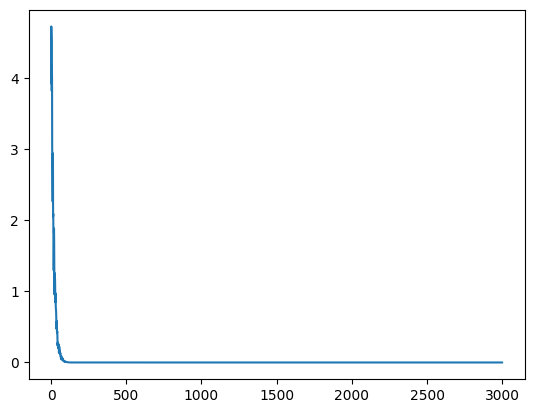

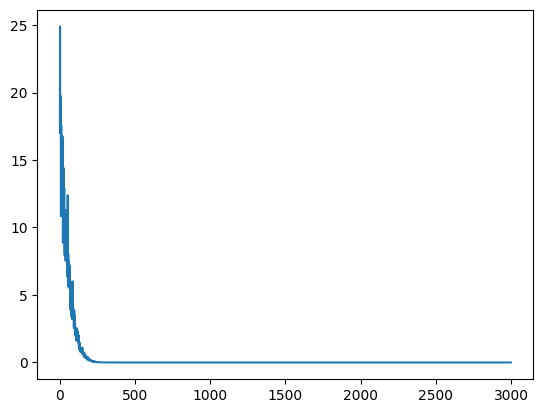

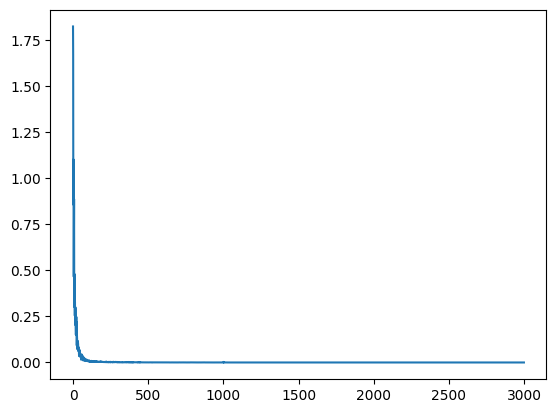

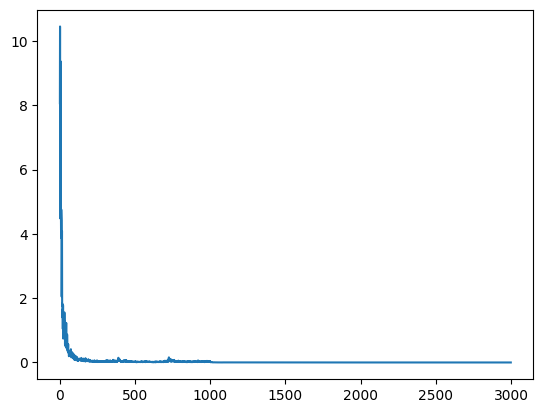

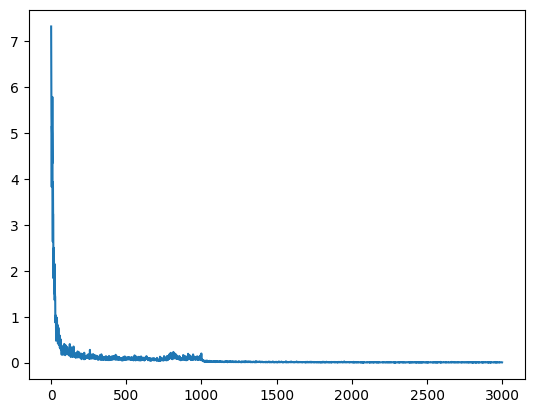

In [ ]:
for log in logs:
    plt.plot(log)
    plt.show()

In [711]:
class Hard_Func(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    def forward(self, x):
        return self.func(x)

In [712]:
size = 7

shape = [size**2, 16, 2]

connections = [(i, j) for k in range(len(shape)-1) for i in range(sum(shape[:k]), sum(shape[:k+1])) for j in range(sum(shape[:k+1]), sum(shape[:k+2]))]
print(len(connections))

graph = NeuralGraph(sum(shape), shape[0], shape[-1], connections, ch_n=4, ch_e=1, clamp_mode="none", value_init="zeros", aggregation="sum", use_label=True, device=device)

graph.inp_int = Hard_Func(desired_inp)# inp_enc.to(device)
graph.out_int = Hard_Func(desired_out)# out_enc.to(device)
graph.label_int = Hard_Func(desired_lbl)# label_enc.to(device)
graph.messages = nn.ModuleList([Hard_Func(desired_message)])# nn.ModuleList([message.to(device)])
graph.updates = nn.ModuleList([Hard_Func(desired_update)])# nn.ModuleList([update.to(device)])

816


In [713]:
class Test_MLP(nn.Module):
    def __init__(self, shape):
        super().__init__()

        modules = []
        for i in range(len(shape)-1):
            modules.append(nn.Linear(shape[i], shape[i+1]))
            modules.append(nn.ReLU())

        self.main = nn.Sequential(*modules)
    
    def forward(self, x):
        return self.main(x)

In [714]:
copycat = Test_MLP(shape).to(device)

edge_states = []
bias_states = []

for layer in copycat.main[::2]:
    # split_bias = torch.repeat_interleave(layer.bias.clone().unsqueeze(-1), layer.weight.shape[1], axis=-1) / layer.weight.shape[1]
    
    edge_states.append(layer.weight.clone().T.reshape(-1, 1))
    bias_states.append(layer.bias.clone())

edge_states = torch.cat(edge_states, axis=0)
bias_states = torch.cat([torch.zeros(shape[0]).to(device), *bias_states], axis=0)

In [715]:
def init_vals(batch_size=1):
    graph.init_vals(batch_size=batch_size)
    graph.edges = edge_states.clone().unsqueeze(0)
    graph.nodes[:, :, 1] = bias_states

init_vals()

In [739]:
init_vals()

dummy_inp = torch.randn(1, 49).to(device)
dummy_label = torch.randn(1, 2).to(device)

print(copycat(dummy_inp))
print(graph.forward(dummy_inp))

tensor([[0.0430, 0.0000]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[0.0430, 0.0000]], device='cuda:0', grad_fn=<SqueezeBackward1>)


In [740]:
copycat.zero_grad()

out = copycat(dummy_inp)
loss = torch.square(dummy_label - out).mean()

print(out, dummy_label, loss)
print(2 * (out - dummy_label))

loss.backward()

print(copycat.main[-2].weight.grad.T.reshape(-1, 1).flatten())
# print(copycat.main[0].weight.grad.T.reshape(-1, 1).flatten()[:32])
real_grads = copycat.main[-2].weight.grad.T.reshape(-1, 1).flatten()

tensor([[0.0430, 0.0000]], device='cuda:0', grad_fn=<ReluBackward0>) tensor([[ 0.1167, -0.6039]], device='cuda:0') tensor(0.1850, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[-0.1473,  1.2077]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([-0.0315,  0.0000, -0.0324,  0.0000, -0.0232,  0.0000, -0.0000,  0.0000,
        -0.0000,  0.0000, -0.0000,  0.0000, -0.0025,  0.0000, -0.0541,  0.0000,
        -0.0388,  0.0000, -0.0000,  0.0000, -0.0473,  0.0000, -0.0000,  0.0000,
        -0.0000,  0.0000, -0.0000,  0.0000, -0.0041,  0.0000, -0.0000,  0.0000],
       device='cuda:0')


In [741]:
init_vals()

pre_w = graph.edges.clone()
# print(graph.edges.flatten()[-32:])

graph.forward(dummy_inp)
graph.backward(dummy_inp, dummy_label, edges=True, edges_at_end=False)
# print(graph.edges.flatten()[-32:])

# print(real_grads / (graph.edges - pre_w).flatten()[-32:])

print(real_grads / ((graph.edges - pre_w).flatten()[-32:] / -lr))
# print(3*(graph.edges - pre_w).flatten()[-32:] / -lr)

# print(4*(graph.edges - pre_w).flatten()[:32] / -lr)
# print(4*(graph.edges - pre_w).flatten()[:32] / -lr)

tensor([1.0000,    nan, 1.0000,    nan, 1.0000,    nan,    nan,    nan,    nan,
           nan,    nan,    nan, 1.0000,    nan, 1.0000,    nan, 1.0000,    nan,
           nan,    nan, 1.0000,    nan,    nan,    nan,    nan,    nan,    nan,
           nan, 0.9999,    nan,    nan,    nan], device='cuda:0',
       grad_fn=<DivBackward0>)


In [742]:
init_vals()
print(graph.forward(dummy_inp, edges=True))

tensor([[0.0430, 0.0000]], device='cuda:0', grad_fn=<SqueezeBackward1>)


In [663]:
ch = 1

init_vals()

graph.apply_vals(dummy_inp)
graph.timestep()
# print(graph.nodes[..., ch])
graph.apply_vals(dummy_inp)
graph.timestep()
# print(graph.nodes[..., ch])
graph.apply_vals(dummy_inp)
graph.timestep()
# print(graph.nodes[..., ch])

pre_w = graph.edges.clone()


# m_e[0] = -lr * n_a[0] * n_b[2] * (1-n_a[3]) * n_b[3]


graph.apply_vals(dummy_inp, dummy_label)
# print(graph.nodes[..., ch])
# print(torch.round(graph.edges[0, -32:, 0], decimals=3))



# print(torch.round(graph.edges[0, -32:, 0] - pre_w[0, -32:, 0], decimals=3))


print()
print(-lr)
print(graph.nodes[0, -18:-2, 0])
print(graph.nodes[0, -2:, 2])
print(1-graph.nodes[0, -18:-2, 3])
print(graph.nodes[0, -2:, 3])
print()


graph.timestep()
# print(graph.nodes[..., ch])
# print(torch.round(graph.edges[0, -32:, 0], decimals=3))

print(torch.round(graph.edges[0, -32:, 0] - pre_w[0, -32:, 0], decimals=3))
graph.apply_vals(dummy_inp, dummy_label)
# print(graph.nodes[..., ch])
# print(torch.round(graph.edges[0, -32:, 0], decimals=3))

print()
print(-lr)
print(graph.nodes[0, -18:-2, 0])
print(graph.nodes[0, -2:, 2])
print(1-graph.nodes[0, -18:-2, 3])
print(graph.nodes[0, -2:, 3])
print()

# print(torch.round(graph.edges[0, -32:, 0] - pre_w[0, -32:, 0], decimals=3))
graph.timestep()
# print(graph.nodes[..., ch])
# print(torch.round(graph.edges[0, -32:, 0], decimals=3))
print(torch.round(graph.edges[0, -32:, 0] - pre_w[0, -32:, 0], decimals=3))
graph.apply_vals(dummy_inp, dummy_label)
# print(graph.nodes[..., ch])
# print(torch.round(graph.edges[0, -32:, 0], decimals=3))
print(torch.round(graph.edges[0, -32:, 0] - pre_w[0, -32:, 0], decimals=3))
graph.timestep()
# print(graph.nodes[..., ch])
# print(torch.round(graph.edges[0, -32:, 0], decimals=3))
print(torch.round(graph.edges[0, -32:, 0] - pre_w[0, -32:, 0], decimals=3))


-0.01
tensor([0.0000, 0.0000, 0.0000, 0.2931, 0.0000, 0.0000, 0.3150, 0.0000, 0.0000,
        0.8445, 0.6160, 0.5097, 0.3784, 0.1470, 0.6932, 0.0000],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-1.3117,  1.7588], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0', grad_fn=<RsubBackward1>)
tensor([1., 1.], device='cuda:0', grad_fn=<SelectBackward0>)

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0040, -0.0050,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0040, -0.0060,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0110, -0.0150,  0.0080, -0.0110,  0.0070, -0.0090,
         0.0050, -0.0070,  0.0020, -0.0030,  0.0090, -0.0120,  0.0000,  0.0000],
       device='cuda:0', grad_fn=<RoundBackward1>)

-0.01
tensor([0.0000, 0.0000, 0.0000, 0.2931, 0.0000, 0.0000, 0.3150, 0.0000, 0.0000,
        0.8445, 0.6160, 0.5097, 0.3784, 0.1470, 0.6932, 0.0000],
       device='cuda

In [506]:
print(message(torch.zeros(1, 2*ch_n+ch_e).to(device)))
print(update(torch.zeros(1, 3*ch_n).to(device)))

tensor([[-7.5434e-09,  3.7796e-08, -7.1157e-09, -5.2946e-07,  1.5004e-02,
          1.2837e-07,  9.2424e-06, -6.4779e-05, -2.1625e-09]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[ 6.9681e-01,  4.6013e-06, -2.0028e-06,  1.1431e-06]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
